In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Read in Data

In [2]:
train_dset = tf.data.experimental.load('../data/dsets/train_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
val_dset = tf.data.experimental.load('../data/dsets/val_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))
test_dset = tf.data.experimental.load('../data/dsets/test_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)))

In [3]:
y_test = np.concatenate([y for x, y in test_dset], axis=0) # for model evaluation
y_test = [np.where(r==1)[0][0] for r in y_test] # convert from one-hot to integer

# Model

In [5]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

num_hidden_units = 256
num_outputs = 7

sequential_model = tf.keras.Sequential([
    tf.keras.Input(shape=(300, 171)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,return_sequences=True,kernel_regularizer='l2')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,kernel_regularizer='l2')),
    tf.keras.layers.Dense(num_outputs,activation='softmax')
])

input_layer = tf.keras.Input(shape=(300, 171)) 
model = tf.keras.Model(inputs=input_layer, outputs=sequential_model(input_layer))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 171)]        0         
_________________________________________________________________
sequential (Sequential)      (None, 7)                 2455047   
Total params: 2,455,047
Trainable params: 2,455,047
Non-trainable params: 0
_________________________________________________________________


In [6]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=50,restore_best_weights=True)
EPOCHS = 300

history = model.fit(train_dset,epochs=EPOCHS,validation_data = val_dset,callbacks=[es])

Epoch 1/300
13/13 [==============================] - 8s 649ms/step - loss: 21.0467 - accuracy: 0.1394 - val_loss: 20.4871 - val_accuracy: 0.1600
Epoch 2/300
13/13 [==============================] - 7s 548ms/step - loss: 20.0410 - accuracy: 0.1575 - val_loss: 19.5049 - val_accuracy: 0.1450
Epoch 3/300
13/13 [==============================] - 7s 547ms/step - loss: 19.0668 - accuracy: 0.1863 - val_loss: 18.5642 - val_accuracy: 0.1900
Epoch 4/300
13/13 [==============================] - 7s 547ms/step - loss: 18.1440 - accuracy: 0.2131 - val_loss: 17.6625 - val_accuracy: 0.2150
Epoch 5/300
13/13 [==============================] - 7s 549ms/step - loss: 17.2501 - accuracy: 0.2344 - val_loss: 16.7758 - val_accuracy: 0.2350
Epoch 6/300
13/13 [==============================] - 7s 550ms/step - loss: 16.3615 - accuracy: 0.2756 - val_loss: 15.9532 - val_accuracy: 0.2400
Epoch 7/300
13/13 [==============================] - 7s 547ms/step - loss: 15.6233 - accuracy: 0.2681 - val_loss: 15.2680 - val_ac

Epoch 56/300
13/13 [==============================] - 7s 545ms/step - loss: 3.7454 - accuracy: 0.6381 - val_loss: 3.8078 - val_accuracy: 0.6200
Epoch 57/300
13/13 [==============================] - 7s 549ms/step - loss: 3.6436 - accuracy: 0.6719 - val_loss: 3.7136 - val_accuracy: 0.6400
Epoch 58/300
13/13 [==============================] - 7s 546ms/step - loss: 3.5871 - accuracy: 0.6744 - val_loss: 3.6886 - val_accuracy: 0.6350
Epoch 59/300
13/13 [==============================] - 7s 549ms/step - loss: 3.5594 - accuracy: 0.6769 - val_loss: 3.6503 - val_accuracy: 0.6450
Epoch 60/300
13/13 [==============================] - 7s 544ms/step - loss: 3.5296 - accuracy: 0.6550 - val_loss: 3.6497 - val_accuracy: 0.6100
Epoch 61/300
13/13 [==============================] - 7s 543ms/step - loss: 3.4959 - accuracy: 0.6637 - val_loss: 3.5829 - val_accuracy: 0.6000
Epoch 62/300
13/13 [==============================] - 7s 544ms/step - loss: 3.4293 - accuracy: 0.6644 - val_loss: 3.5073 - val_accuracy:

Epoch 113/300
13/13 [==============================] - 7s 546ms/step - loss: 2.0058 - accuracy: 0.8531 - val_loss: 2.5626 - val_accuracy: 0.6900
Epoch 114/300
13/13 [==============================] - 7s 546ms/step - loss: 1.9567 - accuracy: 0.8794 - val_loss: 2.5690 - val_accuracy: 0.7050
Epoch 115/300
13/13 [==============================] - 7s 548ms/step - loss: 1.9215 - accuracy: 0.8850 - val_loss: 2.6228 - val_accuracy: 0.6800
Epoch 116/300
13/13 [==============================] - 7s 548ms/step - loss: 1.9289 - accuracy: 0.8775 - val_loss: 2.5546 - val_accuracy: 0.6850
Epoch 117/300
13/13 [==============================] - 7s 545ms/step - loss: 2.0043 - accuracy: 0.8388 - val_loss: 2.5774 - val_accuracy: 0.6650
Epoch 118/300
13/13 [==============================] - 7s 548ms/step - loss: 1.9622 - accuracy: 0.8556 - val_loss: 2.5423 - val_accuracy: 0.6900
Epoch 119/300
13/13 [==============================] - 7s 549ms/step - loss: 1.9681 - accuracy: 0.8381 - val_loss: 2.5911 - val_ac

13/13 [==============================] - 7s 551ms/step - loss: 1.1232 - accuracy: 0.9694 - val_loss: 2.1893 - val_accuracy: 0.6750
Epoch 226/300
13/13 [==============================] - 7s 546ms/step - loss: 1.1818 - accuracy: 0.9456 - val_loss: 2.1290 - val_accuracy: 0.7500
Epoch 227/300
13/13 [==============================] - 7s 549ms/step - loss: 1.1427 - accuracy: 0.9606 - val_loss: 2.2399 - val_accuracy: 0.6850
Epoch 228/300
13/13 [==============================] - 7s 547ms/step - loss: 1.1730 - accuracy: 0.9475 - val_loss: 2.1996 - val_accuracy: 0.6550
Epoch 229/300
13/13 [==============================] - 7s 548ms/step - loss: 1.1665 - accuracy: 0.9481 - val_loss: 2.1966 - val_accuracy: 0.6750
Epoch 230/300
13/13 [==============================] - 7s 545ms/step - loss: 1.1664 - accuracy: 0.9419 - val_loss: 2.1545 - val_accuracy: 0.7050
Epoch 231/300
13/13 [==============================] - 7s 545ms/step - loss: 1.1820 - accuracy: 0.9419 - val_loss: 2.1819 - val_accuracy: 0.6950

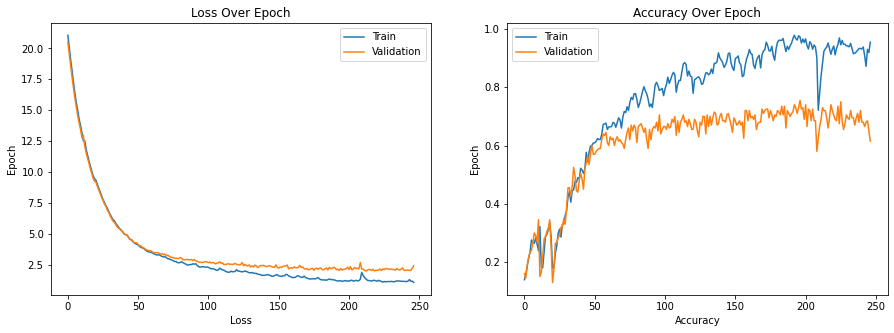

In [7]:
x = np.arange(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Over Epoch")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Over Epoch")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()

plt.close()

# TODO definitely something sketchy with this loss, could be a learning rate thing?

In [8]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

2/2 [==============================] - 0s 96ms/step - loss: 2.0730 - accuracy: 0.7400
Test accuracy: 0.740


In [9]:
# # save model
updateSavedModel = True
if updateSavedModel:
    model.save("trained-models/model_lstm")

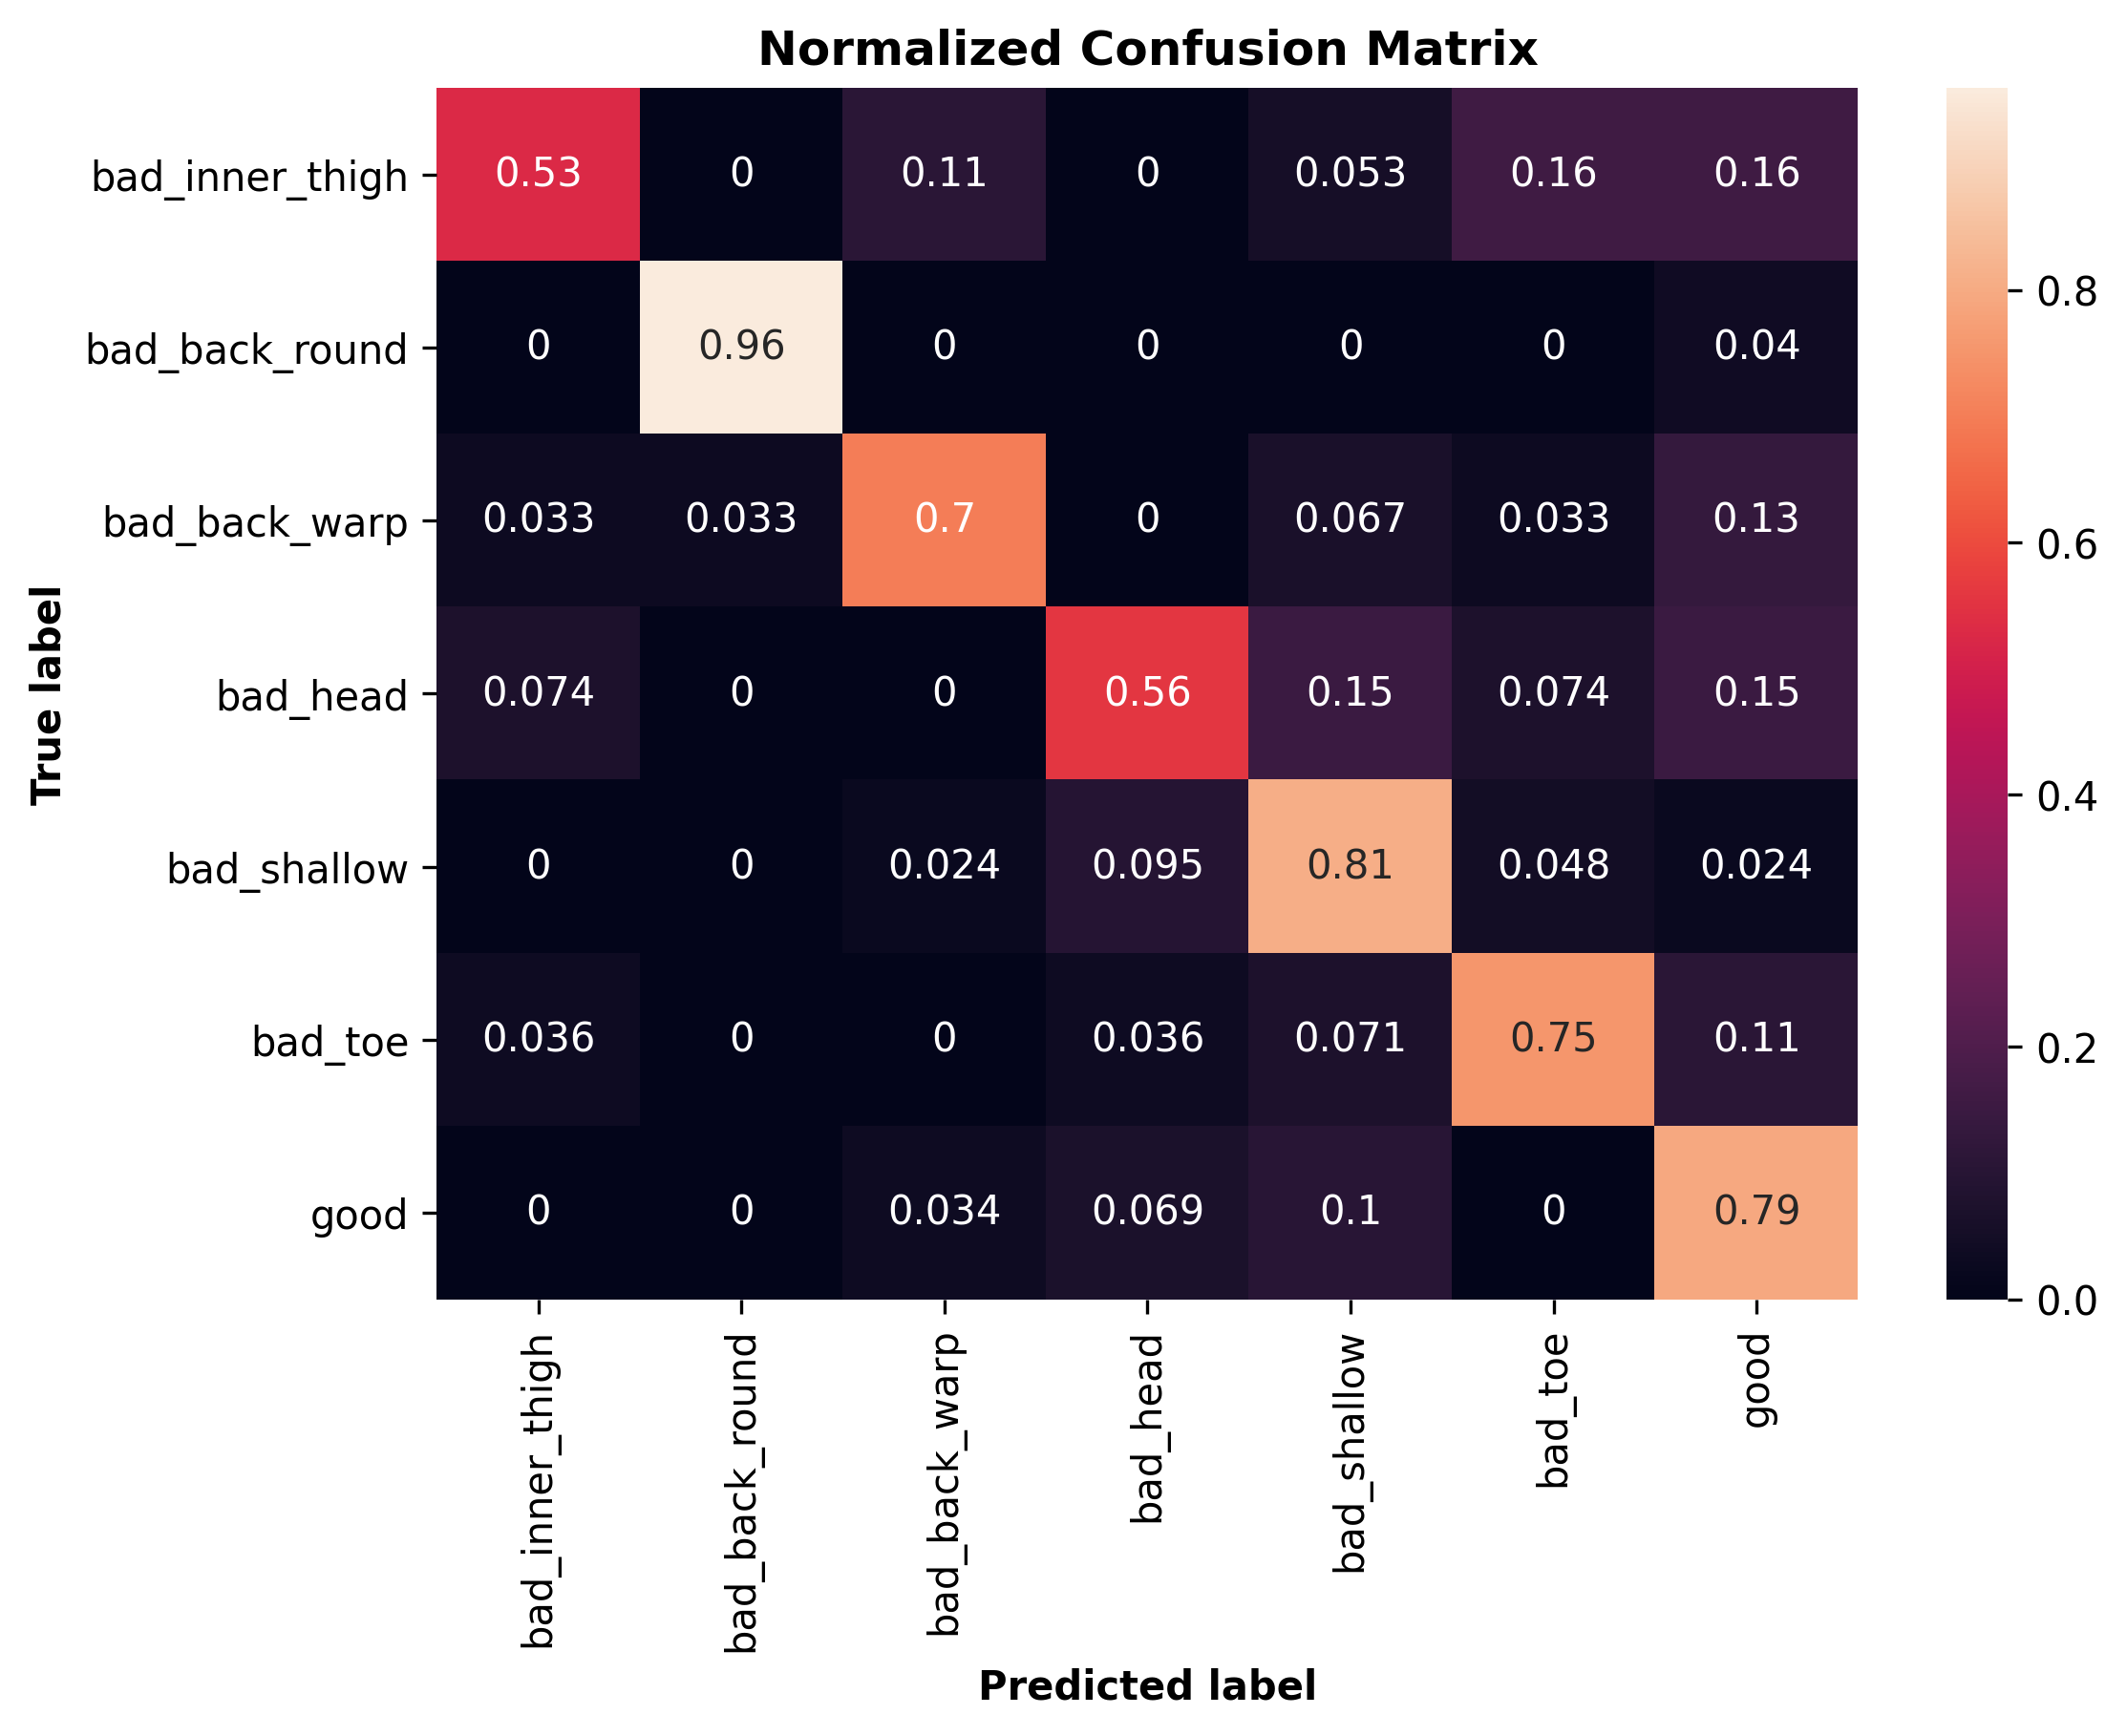


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.75
Macro Recall: 0.73
Macro F1-score: 0.73

Weighted Precision: 0.75
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

                 precision    recall  f1-score   support

bad_inner_thigh       0.71      0.53      0.61        19
 bad_back_round       0.96      0.96      0.96        25
  bad_back_warp       0.84      0.70      0.76        30
       bad_head       0.68      0.56      0.61        27
    bad_shallow       0.74      0.81      0.77        42
        bad_toe       0.72      0.75      0.74        28
           good       0.59      0.79      0.68        29

       accuracy                           0.74       200
      macro avg       0.75      0.73      0.73       200
   weighted avg       0.75      0.74      0.74       200

Cohen Kappa Statistic



0.6931248155798171

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred
display_labels = ['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good']
df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels)
plt.figure(figsize=(8, (7 * 8)/10),dpi=300)
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names=['bad_inner_thigh', 'bad_back_round', 'bad_back_warp', 'bad_head', 'bad_shallow', 'bad_toe', 'good'])
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic\n')
cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)